# Imports & Pre-requisites

In [303]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk import ngrams
import html
from string import punctuation
import csv
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.ensemble import BaggingClassifier
from glove import Corpus, Glove
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict
import zipfile
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#DATA
HEADERS = ["polarity", "id","date","query","user","content", "text_content", "content_with_stopwords", "text_content_with_stopwords"]
SEED=42
TRAIN_SPLIT=0.8

#FILES
TRAIN_FILE_LOC = "data/training.1600000.processed.noemoticon.csv"
TEST_FILE_LOC = "data/testdata.manual.2009.06.14.csv"
DATA_LOC = "data/data.p"
DATA_NO_NEUTRAL_LOC = "data/data-no-neutral.p"
SUPERVISED_RESULTS = "data/supervised-results.p"
GLOVE_MODEL='data/glove.model'
CORPUS_MODEL='data/corpus.model'
GLOVE_VEC_VALUES='data/glove-vec-values.p'
GLOVE_840B_300D_PATH='data/glove.840B.300d.txt'


sns.set(color_codes=True)
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [304]:
%%bash
wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip --directory-prefix=./data

Process is interrupted.


In [23]:
zip = zipfile.ZipFile('data/trainingandtestdata.zip')
zip.extractall(path='./data')

# Initial Data Analysis

In [319]:
training_data = pd.read_csv(TRAIN_FILE_LOC, header=None, encoding='latin-1',names=HEADERS)
test_data = pd.read_csv(TEST_FILE_LOC, header=None, encoding='latin-1',names=HEADERS)

In [320]:
print('merge our data frames... we will split it later into training and tests but if we dont join them here we end up with differeing feature sets.')
data = test_data.append(training_data, ignore_index=True)
print(training_data.shape)
print(test_data.shape)
print(data.shape)

merge our data frames... we will split it later into training and tests but if we dont join them here we end up with differeing feature sets.
(1600000, 9)
(498, 9)
(1600498, 9)


In [321]:
tokenizer = TweetTokenizer()

def convert_tweet_array_to_vector_count(data, word_vector_already=False) :
    word_vector = []
    if(word_vector_already == False) :
        print("tokenizing dataframe")
        word_vector = data["content"].apply(tokenizer.tokenize)
        print("done tokenizing")
    else :
        word_vector = data['content']
    
    print("creating word vector from tokens")
    word_vector = [item for sublist in word_vector for item in sublist]
    word_counts = Counter(word_vector)
    df = pd.DataFrame.from_dict(word_counts, orient='index')
    df = df.sort_values(df.columns[0],ascending = False)
    print("done creating vector")
    return df

def describe_data_set(data, parse_tokenizer = False, positive_polarity_index = 1) :
    
    print("data head:")
    display(data.head())
    
    print("distribution of polarity:")
    fig = sns.kdeplot(np.array(data['polarity']), color='b', bw=0.5, marker='o', label='keyword')
    fig.xaxis.set_major_locator(ticker.MultipleLocator(2))
    plt.show()
    
    df = convert_tweet_array_to_vector_count(data, parse_tokenizer)
    a4_dims = (15, 12)

    top_50 = df.head(100)
    bottom_50 = df.tail(100)
    
    print("top words visualisation:")
    fig, ax = plt.subplots(figsize=a4_dims)
    
    fig = sns.barplot(x=top_50.index.values.tolist(),y=top_50.iloc[:, 0], ax=ax)
    fig.set_xticklabels(top_50.index.values.tolist(), rotation=90)
    
    plt.show()
    
    print("bottom words visualisation:")
    fig2, ax = plt.subplots(figsize=a4_dims)
    fig2 = sns.barplot(x=bottom_50.index.values.tolist(),y=bottom_50.iloc[:, 0], ax=ax)
    fig2.set_xticklabels(bottom_50.index.values.tolist(), rotation=90)
    
    plt.show()
    
    print("any rows with null values:")
    data[data.isnull().any(axis=1)].head()
    
    print("word cloud for positive words")
    tweets = data[data['polarity'] == positive_polarity_index]
    tweet_string = ''
    display(tweets.head())

    for row in tweets['content'] :
        if(parse_tokenizer) :
            for word in row :
                tweet_string += word + ' '
        else :
            tweet_string += row + ' '

    wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweet_string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    print("word cloud for negative words")
    tweets = data[data['polarity'] == 0]
    display(tweets.head())
    tweet_string = ''

    for row in tweets['content'] :
        if(parse_tokenizer) :
            for word in row :
                tweet_string += word + ' '
        else :
            tweet_string += row + ' '

    wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweet_string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    


data head:


polarity  id                          date    query      user  \
0  4         3   Mon May 11 03:17:40 UTC 2009  kindle2  tpryan     
1  4         4   Mon May 11 03:18:03 UTC 2009  kindle2  vcu451     
2  4         5   Mon May 11 03:18:54 UTC 2009  kindle2  chadfu     
3  4         6   Mon May 11 03:19:04 UTC 2009  kindle2  SIX15      
4  4         7   Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                                                                                                        content  \
0  @stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.                                
1  Reading my kindle2...  Love it... Lee childs is good read.                                                                                     
2  Ok, first assesment of the #kindle2 ...it fucking rocks!!!                                                                                     
3  @kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)   
4  @mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)                                                                    

   text_content  content_with_stopwords  text_content_with_stopwords  
0 NaN           NaN                     NaN                           
1 NaN           NaN                     NaN                           
2 NaN           NaN                     NaN                           
3 NaN           NaN                     NaN                           
4 NaN           NaN                     NaN

distribution of polarity:


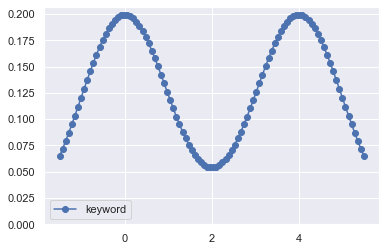

tokenizing dataframe
done tokenizing
creating word vector from tokens
done creating vector
top words visualisation:


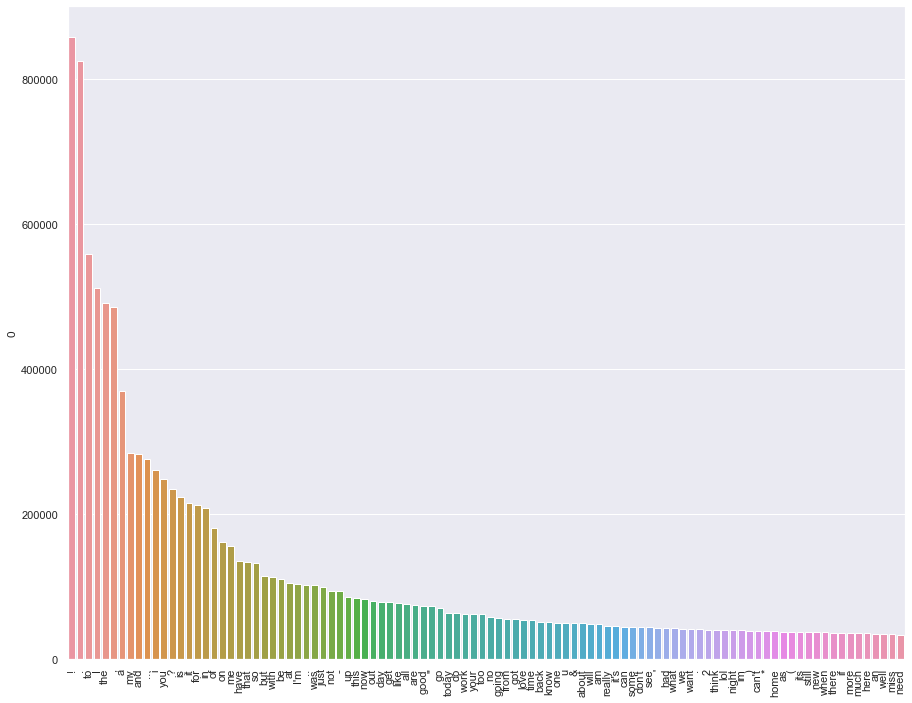

bottom words visualisation:


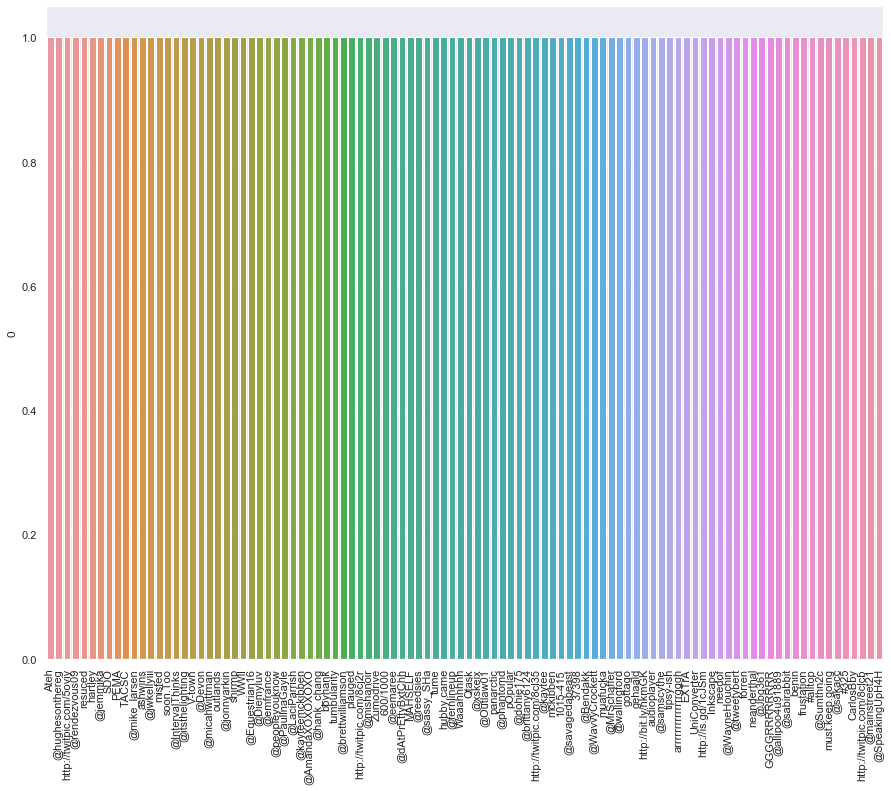

any rows with null values:
word cloud for positive words


polarity  id                          date    query      user  \
0  4         3   Mon May 11 03:17:40 UTC 2009  kindle2  tpryan     
1  4         4   Mon May 11 03:18:03 UTC 2009  kindle2  vcu451     
2  4         5   Mon May 11 03:18:54 UTC 2009  kindle2  chadfu     
3  4         6   Mon May 11 03:19:04 UTC 2009  kindle2  SIX15      
4  4         7   Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                                                                                                        content  \
0  @stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.                                
1  Reading my kindle2...  Love it... Lee childs is good read.                                                                                     
2  Ok, first assesment of the #kindle2 ...it fucking rocks!!!                                                                                     
3  @kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)   
4  @mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)                                                                    

   text_content  content_with_stopwords  text_content_with_stopwords  
0 NaN           NaN                     NaN                           
1 NaN           NaN                     NaN                           
2 NaN           NaN                     NaN                           
3 NaN           NaN                     NaN                           
4 NaN           NaN                     NaN

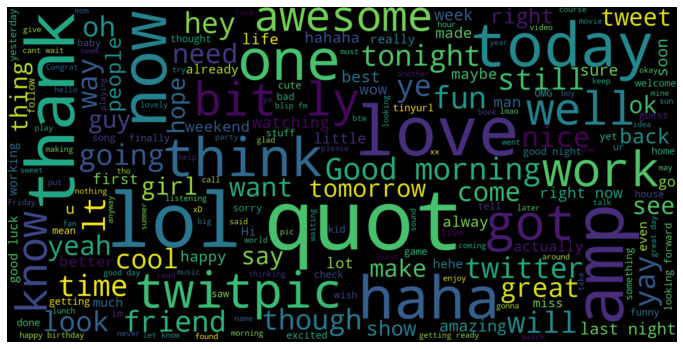

word cloud for negative words


polarity  id                          date   query            user  \
6   0         9   Mon May 11 03:22:30 UTC 2009  aig     Seth937          
11  0         14  Mon May 11 03:32:48 UTC 2009  obama   kylesellers      
14  0         17  Mon May 11 05:06:22 UTC 2009  nike    vincentx24x      
16  0         19  Mon May 11 05:20:28 UTC 2009  lebron  luv8242          
18  0         21  Mon May 11 05:21:37 UTC 2009  lebron  ursecretdezire   

                                                                                                                                         content  \
6   Fuck this economy. I hate aig and their non loan given asses.                                                                                  
11  @Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil.  It's a charade and a slogan, but they want to destroy conservatism   
14  dear nike, stop with the flywire. that shit is a waste of science. and ugly. love, @vincentx24x                                                
16  I was talking to this guy last night and he was telling me that he is a die hard Spurs fan.  He also told me that he hates LeBron James.       
18  @ludajuice Lebron is a Beast, but I'm still cheering 4 the A..til the end.                                                                     

    text_content  content_with_stopwords  text_content_with_stopwords  
6  NaN           NaN                     NaN                           
11 NaN           NaN                     NaN                           
14 NaN           NaN                     NaN                           
16 NaN           NaN                     NaN                           
18 NaN           NaN                     NaN

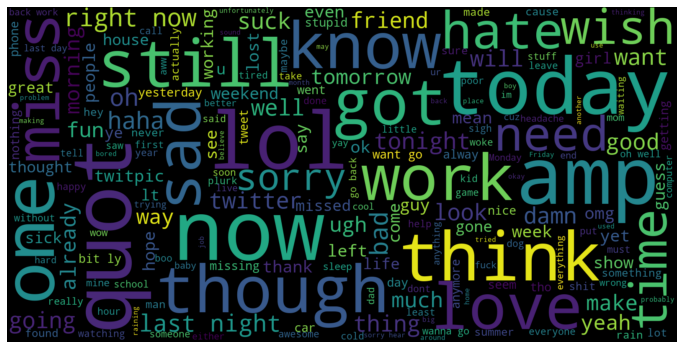

In [322]:
describe_data_set(data, positive_polarity_index=4)

# Data Pre-processing

In [307]:
def expand_contractions(text):
    return contractions.fix(text)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_extra_letters(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1", text)

def fix_misspelled_vectors(vector) :
    for i in range(len(vector)) :
        vector[i] = spell(vector[i])
    
    return vector

stopword = stopwords.words('english')

def remove_stopwords(vector) :
    return [word for word in vector if word not in stopword]

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_words(vector) :
    return [wordnet_lemmatizer.lemmatize(word) for word in vector]

def remove_digits(text) :
    return ''.join(c for c in text if not c.isdigit())

def remove_punctuation(text):
    return ''.join(c for c in text if c not in punctuation)
            
def remove_abbreviations(user_string, abbreviation_list):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        
        # Removing Special Characters.
        _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
        for row in abbreviation_list:
            # Check if selected word matches short forms[LHS] in text file.
            if _str.upper() == row[0]:
                # If match found replace it with its Abbreviation in text file.
                user_string[j] = row[1].lower()
        j = j + 1
    # Replacing commas with spaces for final output.
    return ' '.join(user_string)

def remove_urls(url_string) :
    return re.sub(r"http\S+", "", re.sub(r'www.[^ ]+',"", url_string))

def remove_usernames(tweet_string) :
    return re.sub(r'@[A-Za-z0-9]+','',tweet_string)



In [308]:
def copy_string(string):
    return (string + '.')[:-1]

def clean_data_output(data, start_sentence, previous_value = False, new_value = False, verbose_output = False, parse_vector = True) :
    print(start_sentence)
    if(previous_value != False) :
        print(previous_value)
    if(new_value != False) :
        print(new_value)
    
    if(verbose_output) :
        data_vector = convert_tweet_array_to_vector_count(data, parse_vector == False)
        print("number of unique items in vector",  len(data_vector.index))
    
    print('-------------\n')

def clean_data(data, verbose_output = False) :
    clean_data_output(data, "starting clean", False, False, verbose_output)  
    
    print("first, convert polarity values to between 0 & 1")
    data['polarity'] = data['polarity'].replace(4,1)
    data['polarity'] =data['polarity'].replace(2,0.5)
    
    before_datapoint = copy_string(data['content'][0])
    data['content'] = data['content'].str.lower()
    after_datapoint = data['content'][0]
    clean_data_output(data, "transform to lowercase", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][12])
    data['content'] = data['content'].apply(html.unescape)
    after_datapoint = data['content'][12]
    clean_data_output(data, "html decode characters", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][5])
    data['content'] = data['content'].apply(expand_contractions)
    after_datapoint = data['content'][5]
    clean_data_output(data, "expand contractions", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][122])
    data['content'] = data['content'].apply(remove_urls)
    after_datapoint = data['content'][122]
    clean_data_output(data, "remove urls", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][0])
    data['content'] = data['content'].apply(remove_usernames)
    after_datapoint = data['content'][0]
    clean_data_output(data, "remove usernames", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][0])
    data['content'] = data['content'].apply(remove_punctuation)
    after_datapoint = data['content'][0]
    clean_data_output(data, "remove punctuation", before_datapoint, after_datapoint, verbose_output) 
    
    # File path which consists of Abbreviations.
    fileName = "abbreviations.txt"
    # File Access mode [Read Mode]
    accessMode = "r"
    with open(fileName, accessMode) as myCSVfile:
        # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
        dataFromFile = csv.reader(myCSVfile, delimiter="=")

        before_datapoint = copy_string(data['content'][20])
        data['content'] = data['content'].apply(lambda x: remove_abbreviations(x,dataFromFile))
        after_datapoint = data['content'][20]
        clean_data_output(data, "remove abbreviations", before_datapoint, after_datapoint, verbose_output) 

        myCSVfile.close()
    
    before_datapoint = copy_string(data['content'][122])
    data['content'] = data['content'].apply(remove_digits)
    after_datapoint = data['content'][122]
    clean_data_output(data, "remove digits", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][0])
    data['content'] = data['content'].apply(remove_extra_letters)
    after_datapoint = data['content'][0]
    clean_data_output(data, "remove extra letters", before_datapoint, after_datapoint, verbose_output) 
    
    before_datapoint = copy_string(data['content'][12])
    data['content'] = data['content'].apply(tokenizer.tokenize)
    data['content'] = data['content'].apply(lemmatize_words)
    after_datapoint = data['content'][12]
    clean_data_output(data, "lemmatize words", before_datapoint, after_datapoint, verbose_output, False) 
    
    before_datapoint = data['content'][0].copy()
    data['content_with_stopwords'] = data['content'].copy()
    data['content'] = data['content'].apply(remove_stopwords)
    after_datapoint = data['content'][0]
    clean_data_output(data, "remove stop words", before_datapoint, after_datapoint, verbose_output, False) 
    
    data['polarity']
    
    print('clean done')
    return data


In [309]:
data = clean_data(data)


starting clean
-------------

first, convert polarity values to between 0 & 1
transform to lowercase
@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.
@stellargirl i loooooooovvvvvveee my kindle2. not that the dx is cool, but the 2 is fantastic in its own right.
-------------

html decode characters
house correspondents dinner was last night whoopi, barbara &amp; sherri went, obama got a standing ovation
house correspondents dinner was last night whoopi, barbara & sherri went, obama got a standing ovation
-------------

expand contractions
@richardebaker no. it is too big. i'm quite happy with the kindle2.
@richardebaker no. it is too big. I am quite happy with the kindle2.
-------------

remove urls
here's a case study on how to use viral marketing to add over 10,000 people to your list http://snipr.com/i50oz
here's a case study on how to use viral marketing to add over 10,000 people to your list 
-------------

remove user

In [310]:
data['text_content'] = data['content'].apply(lambda x: ' '.join(x))
data['text_content_with_stopwords'] = data['content_with_stopwords'].apply(lambda x: ' '.join(x))


In [311]:
data.to_pickle(DATA_LOC)

In [323]:
data = pd.read_pickle(DATA_LOC)
display(data.head())

polarity  id                          date    query      user  \
0  1.0       3   Mon May 11 03:17:40 UTC 2009  kindle2  tpryan     
1  1.0       4   Mon May 11 03:18:03 UTC 2009  kindle2  vcu451     
2  1.0       5   Mon May 11 03:18:54 UTC 2009  kindle2  chadfu     
3  1.0       6   Mon May 11 03:19:04 UTC 2009  kindle2  SIX15      
4  1.0       7   Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                                                   content  \
0  [love, kindle, dx, cool, fantastic, right]                                                
1  [reading, kindle, love, lee, child, good, read]                                           
2  [ok, first, assesment, kindle, fucking, rock]                                             
3  [love, kindle, I, mine, month, never, looked, back, new, big, one, huge, need, remorse]   
4  [fair, enough, kindle, think, perfect]                                                    

                                                               text_content  \
0  love kindle dx cool fantastic right                                        
1  reading kindle love lee child good read                                    
2  ok first assesment kindle fucking rock                                     
3  love kindle I mine month never looked back new big one huge need remorse   
4  fair enough kindle think perfect                                           

                                                                                                                                    content_with_stopwords  \
0  [i, love, my, kindle, not, that, the, dx, is, cool, but, the, is, fantastic, in, it, own, right]                                                          
1  [reading, my, kindle, love, it, lee, child, is, good, read]                                                                                               
2  [ok, first, assesment, of, the, kindle, it, fucking, rock]                                                                                                
3  [you, will, love, your, kindle, I, have, had, mine, for, a, few, month, and, never, looked, back, the, new, big, one, is, huge, no, need, for, remorse]   
4  [fair, enough, but, i, have, the, kindle, and, i, think, it, is, perfect]                                                                                 

                                                                                                   text_content_with_stopwords  
0  i love my kindle not that the dx is cool but the is fantastic in it own right                                                
1  reading my kindle love it lee child is good read                                                                             
2  ok first assesment of the kindle it fucking rock                                                                             
3  you will love your kindle I have had mine for a few month and never looked back the new big one is huge no need for remorse  
4  fair enough but i have the kindle and i think it is perfect

describe clean data:
data head:


polarity  id                          date    query      user  \
0  1.0       3   Mon May 11 03:17:40 UTC 2009  kindle2  tpryan     
1  1.0       4   Mon May 11 03:18:03 UTC 2009  kindle2  vcu451     
2  1.0       5   Mon May 11 03:18:54 UTC 2009  kindle2  chadfu     
3  1.0       6   Mon May 11 03:19:04 UTC 2009  kindle2  SIX15      
4  1.0       7   Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                                                   content  \
0  [love, kindle, dx, cool, fantastic, right]                                                
1  [reading, kindle, love, lee, child, good, read]                                           
2  [ok, first, assesment, kindle, fucking, rock]                                             
3  [love, kindle, I, mine, month, never, looked, back, new, big, one, huge, need, remorse]   
4  [fair, enough, kindle, think, perfect]                                                    

                                                               text_content  \
0  love kindle dx cool fantastic right                                        
1  reading kindle love lee child good read                                    
2  ok first assesment kindle fucking rock                                     
3  love kindle I mine month never looked back new big one huge need remorse   
4  fair enough kindle think perfect                                           

                                                                                                                                    content_with_stopwords  \
0  [i, love, my, kindle, not, that, the, dx, is, cool, but, the, is, fantastic, in, it, own, right]                                                          
1  [reading, my, kindle, love, it, lee, child, is, good, read]                                                                                               
2  [ok, first, assesment, of, the, kindle, it, fucking, rock]                                                                                                
3  [you, will, love, your, kindle, I, have, had, mine, for, a, few, month, and, never, looked, back, the, new, big, one, is, huge, no, need, for, remorse]   
4  [fair, enough, but, i, have, the, kindle, and, i, think, it, is, perfect]                                                                                 

                                                                                                   text_content_with_stopwords  
0  i love my kindle not that the dx is cool but the is fantastic in it own right                                                
1  reading my kindle love it lee child is good read                                                                             
2  ok first assesment of the kindle it fucking rock                                                                             
3  you will love your kindle I have had mine for a few month and never looked back the new big one is huge no need for remorse  
4  fair enough but i have the kindle and i think it is perfect

distribution of polarity:


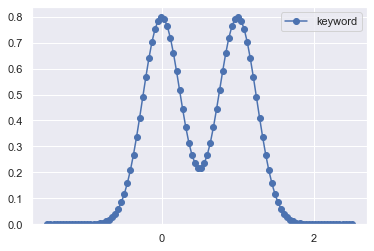

creating word vector from tokens
done creating vector
top words visualisation:


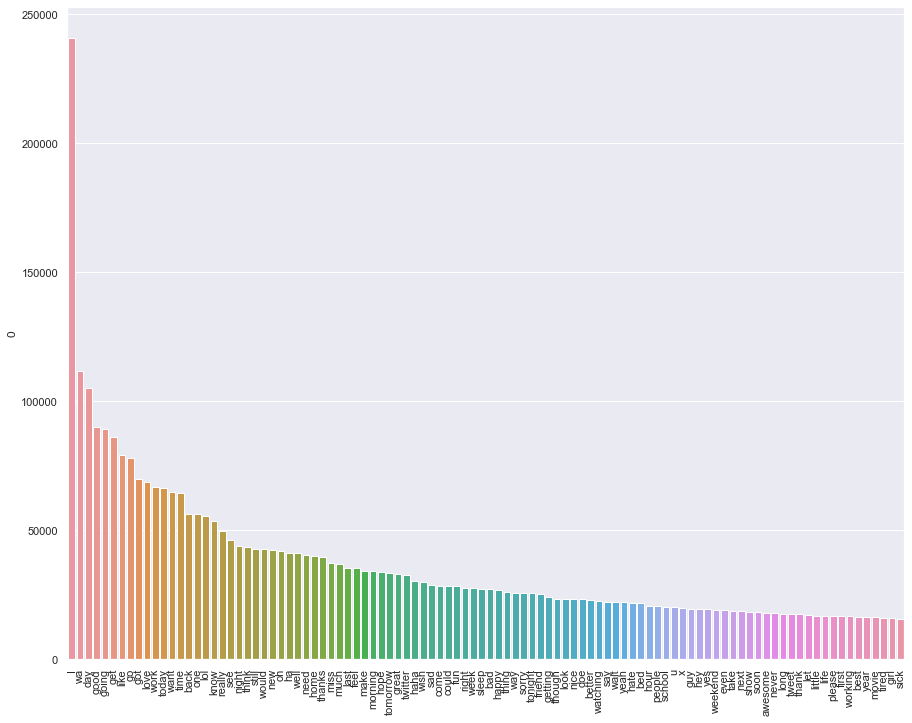

bottom words visualisation:


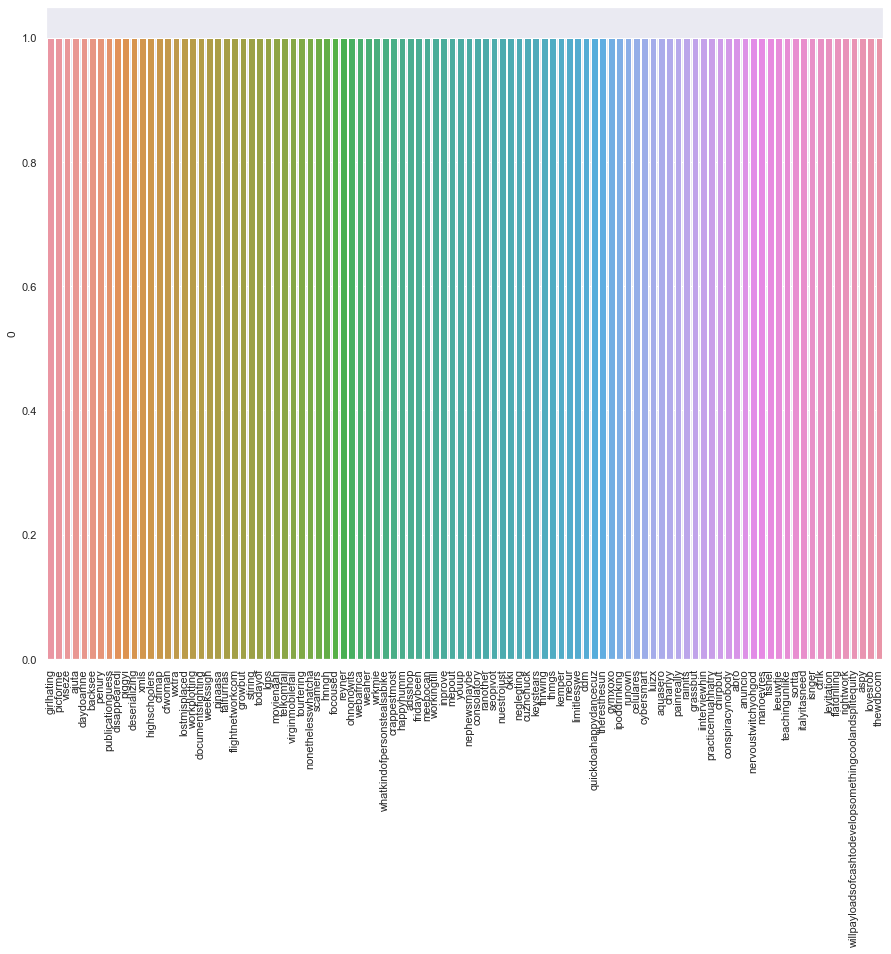

any rows with null values:
word cloud for positive words


polarity  id                          date    query      user  \
0  1.0       3   Mon May 11 03:17:40 UTC 2009  kindle2  tpryan     
1  1.0       4   Mon May 11 03:18:03 UTC 2009  kindle2  vcu451     
2  1.0       5   Mon May 11 03:18:54 UTC 2009  kindle2  chadfu     
3  1.0       6   Mon May 11 03:19:04 UTC 2009  kindle2  SIX15      
4  1.0       7   Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                                                   content  \
0  [love, kindle, dx, cool, fantastic, right]                                                
1  [reading, kindle, love, lee, child, good, read]                                           
2  [ok, first, assesment, kindle, fucking, rock]                                             
3  [love, kindle, I, mine, month, never, looked, back, new, big, one, huge, need, remorse]   
4  [fair, enough, kindle, think, perfect]                                                    

                                                               text_content  \
0  love kindle dx cool fantastic right                                        
1  reading kindle love lee child good read                                    
2  ok first assesment kindle fucking rock                                     
3  love kindle I mine month never looked back new big one huge need remorse   
4  fair enough kindle think perfect                                           

                                                                                                                                    content_with_stopwords  \
0  [i, love, my, kindle, not, that, the, dx, is, cool, but, the, is, fantastic, in, it, own, right]                                                          
1  [reading, my, kindle, love, it, lee, child, is, good, read]                                                                                               
2  [ok, first, assesment, of, the, kindle, it, fucking, rock]                                                                                                
3  [you, will, love, your, kindle, I, have, had, mine, for, a, few, month, and, never, looked, back, the, new, big, one, is, huge, no, need, for, remorse]   
4  [fair, enough, but, i, have, the, kindle, and, i, think, it, is, perfect]                                                                                 

                                                                                                   text_content_with_stopwords  
0  i love my kindle not that the dx is cool but the is fantastic in it own right                                                
1  reading my kindle love it lee child is good read                                                                             
2  ok first assesment of the kindle it fucking rock                                                                             
3  you will love your kindle I have had mine for a few month and never looked back the new big one is huge no need for remorse  
4  fair enough but i have the kindle and i think it is perfect

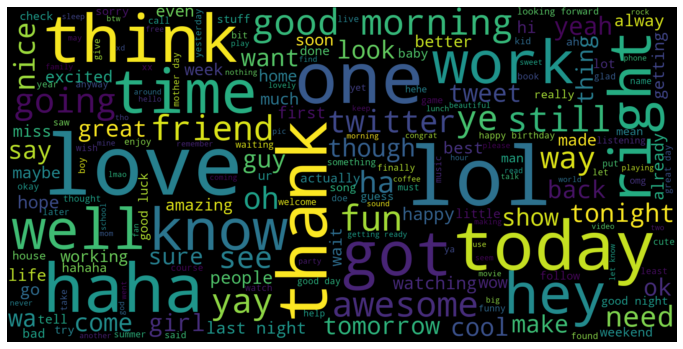

word cloud for negative words


polarity  id                          date   query            user  \
6   0.0       9   Mon May 11 03:22:30 UTC 2009  aig     Seth937          
11  0.0       14  Mon May 11 03:32:48 UTC 2009  obama   kylesellers      
14  0.0       17  Mon May 11 05:06:22 UTC 2009  nike    vincentx24x      
16  0.0       19  Mon May 11 05:20:28 UTC 2009  lebron  luv8242          
18  0.0       21  Mon May 11 05:21:37 UTC 2009  lebron  ursecretdezire   

                                                                                                content  \
6   [fuck, economy, hate, aig, non, loan, given, ass]                                                     
11  [firmly, believe, obamapelosi, zero, desire, civil, charade, slogan, want, destroy, conservatism]     
14  [dear, nike, stop, flywire, shit, waste, science, ugly, love]                                         
16  [wa, talking, guy, last, night, wa, telling, die, hard, spur, fan, also, told, hate, lebron, james]   
18  [lebron, beast, I, still, cheering, atil, end]                                                        

                                                                             text_content  \
6   fuck economy hate aig non loan given ass                                                
11  firmly believe obamapelosi zero desire civil charade slogan want destroy conservatism   
14  dear nike stop flywire shit waste science ugly love                                     
16  wa talking guy last night wa telling die hard spur fan also told hate lebron james      
18  lebron beast I still cheering atil end                                                  

                                                                                                                                              content_with_stopwords  \
6   [fuck, this, economy, i, hate, aig, and, their, non, loan, given, ass]                                                                                             
11  [i, firmly, believe, that, obamapelosi, have, zero, desire, to, be, civil, it, is, a, charade, and, a, slogan, but, they, want, to, destroy, conservatism]         
14  [dear, nike, stop, with, the, flywire, that, shit, is, a, waste, of, science, and, ugly, love]                                                                     
16  [i, wa, talking, to, this, guy, last, night, and, he, wa, telling, me, that, he, is, a, die, hard, spur, fan, he, also, told, me, that, he, hate, lebron, james]   
18  [lebron, is, a, beast, but, I, am, still, cheering, the, atil, the, end]                                                                                           

                                                                                                          text_content_with_stopwords  
6   fuck this economy i hate aig and their non loan given ass                                                                          
11  i firmly believe that obamapelosi have zero desire to be civil it is a charade and a slogan but they want to destroy conservatism  
14  dear nike stop with the flywire that shit is a waste of science and ugly love                                                      
16  i wa talking to this guy last night and he wa telling me that he is a die hard spur fan he also told me that he hate lebron james  
18  lebron is a beast but I am still cheering the atil the end

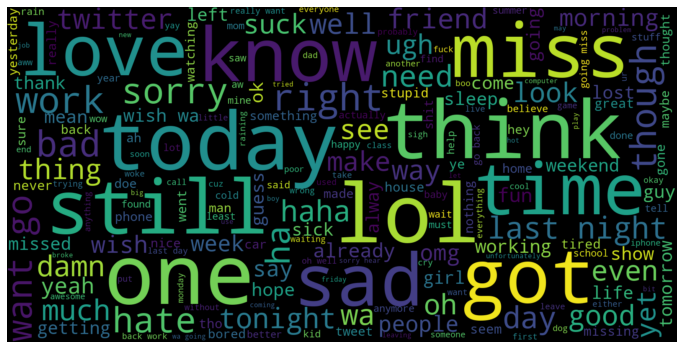

In [317]:
print("describe clean data:")
describe_data_set(data, True)

In [324]:
print('delete any neutral entries from our test data')
data = data[data.polarity != 0.5]
data.to_pickle(DATA_NO_NEUTRAL_LOC)

delete any neutral entries from our test data


In [325]:
data = pd.read_pickle(DATA_NO_NEUTRAL_LOC)
display(data.head())

polarity  id                          date    query      user  \
0  1.0       3   Mon May 11 03:17:40 UTC 2009  kindle2  tpryan     
1  1.0       4   Mon May 11 03:18:03 UTC 2009  kindle2  vcu451     
2  1.0       5   Mon May 11 03:18:54 UTC 2009  kindle2  chadfu     
3  1.0       6   Mon May 11 03:19:04 UTC 2009  kindle2  SIX15      
4  1.0       7   Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                                                   content  \
0  [love, kindle, dx, cool, fantastic, right]                                                
1  [reading, kindle, love, lee, child, good, read]                                           
2  [ok, first, assesment, kindle, fucking, rock]                                             
3  [love, kindle, I, mine, month, never, looked, back, new, big, one, huge, need, remorse]   
4  [fair, enough, kindle, think, perfect]                                                    

                                                               text_content  \
0  love kindle dx cool fantastic right                                        
1  reading kindle love lee child good read                                    
2  ok first assesment kindle fucking rock                                     
3  love kindle I mine month never looked back new big one huge need remorse   
4  fair enough kindle think perfect                                           

                                                                                                                                    content_with_stopwords  \
0  [i, love, my, kindle, not, that, the, dx, is, cool, but, the, is, fantastic, in, it, own, right]                                                          
1  [reading, my, kindle, love, it, lee, child, is, good, read]                                                                                               
2  [ok, first, assesment, of, the, kindle, it, fucking, rock]                                                                                                
3  [you, will, love, your, kindle, I, have, had, mine, for, a, few, month, and, never, looked, back, the, new, big, one, is, huge, no, need, for, remorse]   
4  [fair, enough, but, i, have, the, kindle, and, i, think, it, is, perfect]                                                                                 

                                                                                                   text_content_with_stopwords  
0  i love my kindle not that the dx is cool but the is fantastic in it own right                                                
1  reading my kindle love it lee child is good read                                                                             
2  ok first assesment of the kindle it fucking rock                                                                             
3  you will love your kindle I have had mine for a few month and never looked back the new big one is huge no need for remorse  
4  fair enough but i have the kindle and i think it is perfect

# Word Embedding

N-Gram Vectorisation

In [2]:
def create_one_grams(data) :    
    return data

def __bigrams(tweets):
    bigrams = [' '.join(t) for t in list(zip(tweets, tweets[1:]))]
    return bigrams

def create_bigram(data) :
    return data.apply(lambda x: __bigrams(x))

def create_sparse_matrix_gram(data, n_gram_size) :
    cv2 = CountVectorizer(ngram_range=(1, n_gram_size))

    vectorized_data = cv2.fit_transform(data)
    return vectorized_data

def create_sparse_matrix_tfidf_gram(data, n_gram_size) :
    tfidf = TfidfVectorizer(ngram_range=(1, n_gram_size))

    vectorized_data = tfidf.fit_transform(data)
    return vectorized_data

def pickle_data(data) :
    print("pickle it!")
    
    data.to_pickle(FINAL_DATAFRAME_FILE_LOC)

def unpickle_data() :
    print("from pickle!")
    data = pd.read_pickle(FINAL_DATAFRAME_FILE_LOC)
    display(data.head())
    return data

def pickle_inputs(X, INPUT_FILE) :
    print("pickle it!")
   
    pickle.dump( X, open(INPUT_FILE , "wb" ) )

def unpickle_inputs(INPUT_FILE) :
    print("from pickle!")
    X = pickle.load( open( INPUT_FILE, "rb" ) )
    return X

In [38]:


print(data.shape)
print(training_data.shape)
print(test_data.shape)
print(data['polarity'].unique())

delete any neutral entries from our test data
merge our data frames... we will split it later into training and tests but if we dont join them here we end up with differeing feature sets.
(1600359, 9)
(1600000, 9)
(359, 9)
[0 4]


In [39]:


X_dict = {
    "onegram_vectors": create_sparse_matrix_gram(data['text_content'], 1),
    "bigram_vectors": create_sparse_matrix_gram(data['text_content'], 2),
    "trigram_vectors": create_sparse_matrix_gram(data['text_content'], 3),
    "tfidf_onegram_vectors": create_sparse_matrix_tfidf_gram(data['text_content'], 1),
    "tfidf_bigram_vectors": create_sparse_matrix_tfidf_gram(data['text_content'], 2),
    "tfidf_trigram_vectors": create_sparse_matrix_tfidf_gram(data['text_content'], 3),
}


In [40]:
pickle_inputs(X_dict, X_INPUT_FILE_LOC)

pickle it!


In [41]:
X_dict = unpickle_inputs(X_INPUT_FILE_LOC)


from pickle!


In [42]:

data['onegram'] = create_one_grams(data['content'])
data['bigrams'] = create_bigram(data['content'])
pickle_data(data)



pickle it!


In [3]:
data = unpickle_data()

from pickle!


polarity          id                          date     query  \
0  0         1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1  0         1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2  0         1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3  0         1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4  0         1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user  \
0  _TheSpecialOne_   
1  scotthamilton     
2  mattycus          
3  ElleCTF           
4  Karoli            

                                                                             content  \
0  [aw, bummer, shoulda, got, david, carr, third, day]                                 
1  [upset, update, facebook, texting, might, cry, result, school, today, also, blah]   
2  [dived, many, time, ball, managed, save, rest, go, bound]                           
3  [whole, body, feel, itchy, like, fire]                                              
4  [behaving, I, mad, see]                                                             

                                                            text_content  \
0  aw bummer shoulda got david carr third day                              
1  upset update facebook texting might cry result school today also blah   
2  dived many time ball managed save rest go bound                         
3  whole body feel itchy like fire                                         
4  behaving I mad see                                                      

                                                                             onegram  \
0  [aw, bummer, shoulda, got, david, carr, third, day]                                 
1  [upset, update, facebook, texting, might, cry, result, school, today, also, blah]   
2  [dived, many, time, ball, managed, save, rest, go, bound]                           
3  [whole, body, feel, itchy, like, fire]                                              
4  [behaving, I, mad, see]                                                             

                                                                             bigrams  
0  [aw, bummer, shoulda, got, david, carr, third, day]                                
1  [upset, update, facebook, texting, might, cry, result, school, today, also, blah]  
2  [dived, many, time, ball, managed, save, rest, go, bound]                          
3  [whole, body, feel, itchy, like, fire]                                             
4  [behaving, I, mad, see]

gloVes

In [52]:
# creating a corpus object
corpus_model = Corpus() 

#training the corpus to generate the co occurence matrix which is used in GloVe
corpus_model.fit(data['content'], window=10)

corpus_model.save(CORPUS_MODEL)


In [53]:
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
corpus_model = Corpus.load(CORPUS_MODEL)
glove = Glove(no_components=5, learning_rate=0.05)
 
glove.fit(corpus_model.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus_model.dictionary)
glove.save(GLOVE_MODEL)

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [54]:
corpus_model = Corpus.load(CORPUS_MODEL)
glove = Glove.load(GLOVE_MODEL)
glove.add_dictionary(corpus_model.dictionary)

In [55]:
glove_vec = {}
all_words = set(w for words in data['content'] for w in words)

for word in all_words :
    if word not in glove_vec :
        glove_vec[word] = glove.word_vectors[glove.dictionary[word]]
        

In [56]:
pickle_inputs(glove_vec, GLOVE_VEC_VALUES)
glove_vec = unpickle_inputs(GLOVE_VEC_VALUES)

pickle it!
from pickle!


In [5]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[data['content'][0][0]])
        else:
            self.dim=0
        
    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [58]:
tdidf_vectorizer = TfidfEmbeddingVectorizer(glove_vec)
mean_vectorizer = MeanEmbeddingVectorizer(glove_vec)

tdidf_vectorizer.fit(data['content'])
glove_tdidf_input_vectors = tdidf_vectorizer.transform(data['content'])
glove_mean_input_vectors = mean_vectorizer.transform(data['content'])

print(glove_tdidf_input_vectors[0])
print(glove_mean_input_vectors[0])

[-3.7197375   4.08172057 -2.87356709 -2.51854875 -3.08905453]


In [59]:
X_dict['mean_glove'] = glove_mean_input_vectors
X_dict['tdidf_glove'] = glove_tdidf_input_vectors

pickle_inputs(X_dict, X_INPUT_FILE_LOC)

pickle it!


In [11]:
X_dict = unpickle_inputs(X_INPUT_FILE_LOC)

from pickle!


In [61]:
%%bash
wget http://nlp.stanford.edu/data/glove.840B.300d.zip --directory-prefix=./data

--2019-08-16 17:29:49--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2019-08-16 17:29:49--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2019-08-16 17:29:50--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [4]:
zip = zipfile.ZipFile('data/glove.840B.300d.zip')
zip.extractall(path='./data')

In [8]:
pretrained_glove_vec = {}
all_words = set(w for words in data['content'] for w in words)
with open(GLOVE_840B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in all_words:
            if word not in pretrained_glove_vec :
                nums=np.array(parts[1:], dtype=np.float32)
                pretrained_glove_vec[word] = nums

In [9]:
tdidf_vectorizer = TfidfEmbeddingVectorizer(pretrained_glove_vec)
mean_vectorizer = MeanEmbeddingVectorizer(pretrained_glove_vec)

tdidf_vectorizer.fit(data['content'])
pretrained_glove_tdidf_input_vectors = tdidf_vectorizer.transform(data['content'])
pretrained_glove_mean_input_vectors = mean_vectorizer.transform(data['content'])

print(pretrained_glove_tdidf_input_vectors[0])
print(pretrained_glove_mean_input_vectors[0])

[-9.30306196e-01  1.40240216e+00 -1.57246351e-01 -1.37864304e+00
 -4.24830079e-01 -4.24961150e-01  5.24019599e-01 -2.30187249e+00
 -1.01471901e+00  6.59346819e+00 -8.15635562e-01 -4.90001231e-01
  1.36685824e+00 -7.99113452e-01 -7.28157818e-01  3.24472964e-01
  1.72947809e-01  1.24619436e+00  7.88865611e-02 -4.85804200e-01
  1.00018549e+00  1.78041145e-01 -1.65717453e-02  7.10566118e-02
  6.69709742e-02 -1.86512148e+00 -1.72056592e+00 -7.34705508e-01
  5.52554786e-01  1.25734293e+00 -1.53002596e+00 -2.20257461e-01
  1.60552132e+00  1.80251288e+00 -1.38761735e+00  2.64114380e-01
  7.87128091e-01  2.27835387e-01 -1.43838263e+00  1.82098001e-01
  1.94446206e-01 -4.70057845e-01 -2.00772390e-01  1.49311900e+00
  7.61961460e-01  1.33823842e-01 -7.30359733e-01 -1.23260343e+00
  1.88788724e+00  1.55380881e+00  1.10505545e+00  4.29653674e-01
  1.52804077e+00  5.78258812e-01  1.03942893e-01  5.64051211e-01
  4.65421617e-01  7.79129148e-01  6.17033660e-01 -1.12600732e+00
 -1.71877909e+00  3.96615

In [12]:
X_dict['pretrained_tdidf_glove'] = pretrained_glove_tdidf_input_vectors
X_dict['pretrained_mean_glove'] = pretrained_glove_mean_input_vectors

pickle_inputs(X_dict, X_INPUT_FILE_LOC)

pickle it!


In [13]:
X_dict = unpickle_inputs(X_INPUT_FILE_LOC)

from pickle!


# Supervised Learning Methods

In [14]:
X = {}
scaler = StandardScaler(with_mean=False)
for key, X_value in X_dict.items():
    X[key] = train_test_split(X_dict[key], data['polarity'], test_size=0.1, random_state=SEED)

In [15]:
pickle_inputs(X, ZIPPED_X_INPUT_FILE_LOC)


pickle it!


In [4]:
X = unpickle_inputs(ZIPPED_X_INPUT_FILE_LOC)

from pickle!


In [5]:

def train_predict(learner, sample_size, X_train, Y_train, X_test, Y_test, sample_type, sample_size_string):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    clf_name = learner.__class__.__name__
    
    if (clf_name == 'MultinomialNB' and type(X_train).__module__ == 'numpy') :
        X_train = np.clip(X_train,a_min=0, a_max=None)
        X_test = np.clip(X_test, a_min=0, a_max=None)

    
    results = {}
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], Y_train[:sample_size])
    end = time() # Get end time
    
    results["clf_name"] = clf_name
    results["input_vector"] = sample_type
    results["sample_size_string"] = sample_size_string
    results["sample_size"] = sample_size
    results["table_key"] = clf_name + ":" + results["input_vector"]
    results["unique_key"] = clf_name + ":" + results["input_vector"] + ":" + sample_size_string

    # TODO: Calculate the training time
    results['train_time'] = end - start

    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time

    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start

    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(Y_train[:300], predictions_train)

    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(Y_test, predictions_test)

    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(Y_train[:300], predictions_train, beta=0.5, pos_label=4)

    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(Y_test, predictions_test, average='binary', beta=0.5, pos_label=4)

    # Success
    print ("{} trained on {} samples of type {}".format(learner.__class__.__name__, sample_size, sample_type))

    # Return the results
    return results


In [10]:
clfs = [
    LogisticRegression(random_state=SEED, n_jobs=-1, verbose=1),
    MultinomialNB(),
]

def get_sample_size(key) :
    if(key == 0) : return "1%"
    elif(key == 1) : return "10%"
    elif(key == 2) : return "50%"
    else : return "100%"

sample_sizes = [
    int(len(X['glove'][0])/100),
    int((len(X['glove'][0]) * 10)/100),
    int((len(X['glove'][0]) * 50)/100),
    len(X['glove'][0])
]

parallel_arguments = []

def worker(parallel_arg) :
    results = []
    for i, samples in enumerate(parallel_arg["sample_sizes"]):    
        results.append(train_predict(parallel_arg["clf"], samples, X[parallel_arg["input_vector"]][0], \
                             X[parallel_arg["input_vector"]][2],  X[parallel_arg["input_vector"]][1], \
                             X[parallel_arg["input_vector"]][3], parallel_arg["input_vector"], get_sample_size(i)))
    return results

num_processors = 12
p=Pool(processes = num_processors)

In [39]:
        
for clf in clfs:
    clf_name = clf.__class__.__name__
    for input_vector in X:
        parallel_arguments.append({
            "clf_name": clf_name,
            "clf": clf,
            "input_vector": input_vector,
            "sample_sizes": sample_sizes
        })
        
supervised_results = p.map(worker,parallel_arguments)
supervised_results = np.asarray(supervised_results).flatten()

display(supervised_results)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3

MultinomialNB trained on 16003 samples of type glove
[LibLinear]LogisticRegression trained on 16003 samples of type glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 16003 samples of type onegram_vectors
MultinomialNB trained on 160035 samples of type glove
MultinomialNB trained on 16003 samples of type bigram_vectors
MultinomialNB trained on 160035 samples of type onegram_vectors
MultinomialNB trained on 800179 samples of type glove
[LibLinear]LogisticRegression trained on 160035 samples of type glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 800179 samples of type onegram_vectors
MultinomialNB trained on 1600359 samples of type glove
MultinomialNB trained on 160035 samples of type bigram_vectors
[LibLinear]LogisticRegression trained on 16003 samples of type onegram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 1600359 samples of type onegram_vectors
MultinomialNB trained on 800179 samples of type bigram_vectors
MultinomialNB trained on 16003 samples of type pretrained_glove
[LibLinear]LogisticRegression trained on 16003 samples of type pretrained_glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]LogisticRegression trained on 800179 samples of type glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 1600359 samples of type bigram_vectors
[LibLinear]LogisticRegression trained on 16003 samples of type bigram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 160035 samples of type pretrained_glove
[LibLinear]LogisticRegression trained on 1600359 samples of type glove
MultinomialNB trained on 800179 samples of type pretrained_glove
[LibLinear]LogisticRegression trained on 160035 samples of type onegram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 1600359 samples of type pretrained_glove
[LibLinear]LogisticRegression trained on 160035 samples of type bigram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibLinear]LogisticRegression trained on 160035 samples of type pretrained_glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibLinear]LogisticRegression trained on 800179 samples of type onegram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibLinear]LogisticRegression trained on 800179 samples of type pretrained_glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibLinear]LogisticRegression trained on 1600359 samples of type onegram_vectors
[LibLinear]LogisticRegression trained on 800179 samples of type bigram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibLinear]LogisticRegression trained on 1600359 samples of type pretrained_glove
[LibLinear]LogisticRegression trained on 1600359 samples of type bigram_vectors


array([{'clf_name': 'LogisticRegression', 'input_vector': 'onegram_vectors', 'sample_size_string': '1%', 'sample_size': 16003, 'table_key': 'LogisticRegression:onegram_vectors', 'unique_key': 'LogisticRegression:onegram_vectors:1%', 'train_time': 4.844507694244385, 'pred_time': 0.035346031188964844, 'acc_train': 0.89, 'acc_test': 0.7283986103126796, 'f_train': 0.8577405857740585, 'f_test': 0.7266040779268446},
       {'clf_name': 'LogisticRegression', 'input_vector': 'onegram_vectors', 'sample_size_string': '10%', 'sample_size': 160035, 'table_key': 'LogisticRegression:onegram_vectors', 'unique_key': 'LogisticRegression:onegram_vectors:10%', 'train_time': 15.030232906341553, 'pred_time': 0.02199411392211914, 'acc_train': 0.8266666666666667, 'acc_test': 0.7597103151790847, 'f_train': 0.7869742198100406, 'f_test': 0.7562493990962408},
       {'clf_name': 'LogisticRegression', 'input_vector': 'onegram_vectors', 'sample_size_string': '50%', 'sample_size': 800179, 'table_key': 'LogisticRegr

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3

MultinomialNB trained on 16003 samples of type glove
MultinomialNB trained on 16003 samples of type onegram_vectors
[LibLinear]LogisticRegression trained on 16003 samples of type glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 160035 samples of type onegram_vectors
MultinomialNB trained on 160035 samples of type glove
MultinomialNB trained on 16003 samples of type bigram_vectors
MultinomialNB trained on 800179 samples of type glove
[LibLinear]LogisticRegression trained on 160035 samples of type glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


MultinomialNB trained on 800179 samples of type onegram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 1600359 samples of type glove
MultinomialNB trained on 1600359 samples of type onegram_vectors
MultinomialNB trained on 160035 samples of type bigram_vectors
MultinomialNB trained on 800179 samples of type bigram_vectors
[LibLinear]LogisticRegression trained on 16003 samples of type onegram_vectors
MultinomialNB trained on 16003 samples of type pretrained_glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibLinear]LogisticRegression trained on 800179 samples of type glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]LogisticRegression trained on 16003 samples of type pretrained_glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 1600359 samples of type bigram_vectors
[LibLinear]LogisticRegression trained on 16003 samples of type bigram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


MultinomialNB trained on 160035 samples of type pretrained_glove
[LibLinear]LogisticRegression trained on 1600359 samples of type glove
MultinomialNB trained on 800179 samples of type pretrained_glove
MultinomialNB trained on 1600359 samples of type pretrained_glove
[LibLinear]LogisticRegression trained on 160035 samples of type onegram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibSVM]SVC trained on 10000 samples of type glove
[LibLinear]LogisticRegression trained on 160035 samples of type bigram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibLinear]LogisticRegression trained on 160035 samples of type pretrained_glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibLinear]LogisticRegression trained on 800179 samples of type onegram_vectors


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:


[LibSVM]SVC trained on 10000 samples of type onegram_vectors
[LibSVM]SVC trained on 10000 samples of type bigram_vectors
[LibLinear]LogisticRegression trained on 800179 samples of type pretrained_glove


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1541: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(self.n_jobs) != 1:
Process ForkPoolWorker-101:
Process ForkPoolWorker-107:
Process ForkPoolWorker-102:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-99:
Process ForkPoolWorker-97:
Process ForkPoolWorker-103:
Process ForkPoolWorker-104:
Process ForkPoolWorker-100:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/

  File "<ipython-input-24-909b9ad9c48c>", line 24, in train_predict
    learner.fit(X_train[:sample_size], Y_train[:sample_size])
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py", line 1549, in fit
    sample_weight=sample_weight)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py", line 921, in _fit_liblinear
    epsilon, sample_weight)
KeyboardInterrupt


[LibLinear]

Process ForkPoolWorker-98:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-39-5d15bf6a9e2e>", line 34, in worker
    results.append(train_predict(parallel_arg["clf"], samples, X[parallel_arg["input_vector"]][0],                              X[parallel_arg["input_vector"]][2],  X[parallel_arg["input_vector"]][1],                              X[parallel_arg["input_vector"]][3], parallel_arg["input_vec

[LibSVM]

Process ForkPoolWorker-106:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-39-5d15bf6a9e2e>", line 34, in worker
    results.append(train_predict(parallel_arg["clf"], samples, X[parallel_arg["input_vector"]][0],                              X[parallel_arg["input_vector"]][2],  X[parallel_arg["input_vector"]][1],                              X[parallel_arg["input_vector"]][3], parallel_arg["input_ve

[LibLinear]

Process ForkPoolWorker-108:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-39-5d15bf6a9e2e>", line 34, in worker
    results.append(train_predict(parallel_arg["clf"], samples, X[parallel_arg["input_vector"]][0],                              X[parallel_arg["input_vector"]][2],  X[parallel_arg["input_vector"]][1],                              X[parallel_arg["input_vector"]][3], parallel_arg["input_ve

[LibLinear]

In [45]:
pickle_inputs(supervised_results, SUPERVISED_RESULTS)

pickle it!


In [6]:
supervised_results = unpickle_inputs(SUPERVISED_RESULTS)
supervised_results_df = pd.DataFrame.from_records(supervised_results)

from pickle!


run svc seperately due to speed and memory issues

In [11]:
clf = SVC(random_state=SEED, kernel='linear', verbose=1)
clf_name = clf.__class__.__name__
svc_supervised_results=[]
parallel_arguments = []
parallel_arguments.append({
    "clf_name": clf_name,
    "clf": clf,
    "input_vector": "onegram_vectors",
    "sample_sizes": [5000]
})

parallel_arguments.append({
    "clf_name": clf_name,
    "clf": clf,
    "input_vector": "bigram_vectors",
    "sample_sizes": [5000]
})

parallel_arguments.append({
    "clf_name": clf_name,
    "clf": clf,
    "input_vector": "pretrained_glove",
    "sample_sizes": [5000]
})

parallel_arguments.append({
    "clf_name": clf_name,
    "clf": clf,
    "input_vector": "glove",
    "sample_sizes": [10000]
})


svc_supervised_results = list(map(worker, parallel_arguments))
print(svc_supervised_results)
svc_supervised_results = np.asarray(svc_supervised_results).flatten()


[LibSVM]SVC trained on 10000 samples of type glove
[[{'clf_name': 'SVC', 'input_vector': 'glove', 'sample_size_string': '1%', 'sample_size': 10000, 'table_key': 'SVC:glove', 'unique_key': 'SVC:glove:1%', 'train_time': 5.488145112991333, 'pred_time': 12.46476697921753, 'acc_train': 0.6133333333333333, 'acc_test': 0.6186732985078357, 'f_train': 0.5742821473158553, 'f_test': 0.6207868285510851}]]


In [12]:
supervised_results = np.concatenate((supervised_results,svc_supervised_results))


In [13]:
pickle_inputs(supervised_results, SUPERVISED_RESULTS)

pickle it!


In [14]:
supervised_results = unpickle_inputs(SUPERVISED_RESULTS)
supervised_results_df = pd.DataFrame.from_records(supervised_results)

from pickle!


In [15]:
def plot_variable(title, key) :
    plt.figure(figsize=(15, 6))
    fig = sns.pointplot(x='sample_size', y=key, hue='table_key', 
                        data=supervised_results_df)
    sns.set_context("notebook", font_scale=1.5)
    fig.set(ylabel=key)
    fig.set(xlabel="Size of training data")
    fig.set(title=title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



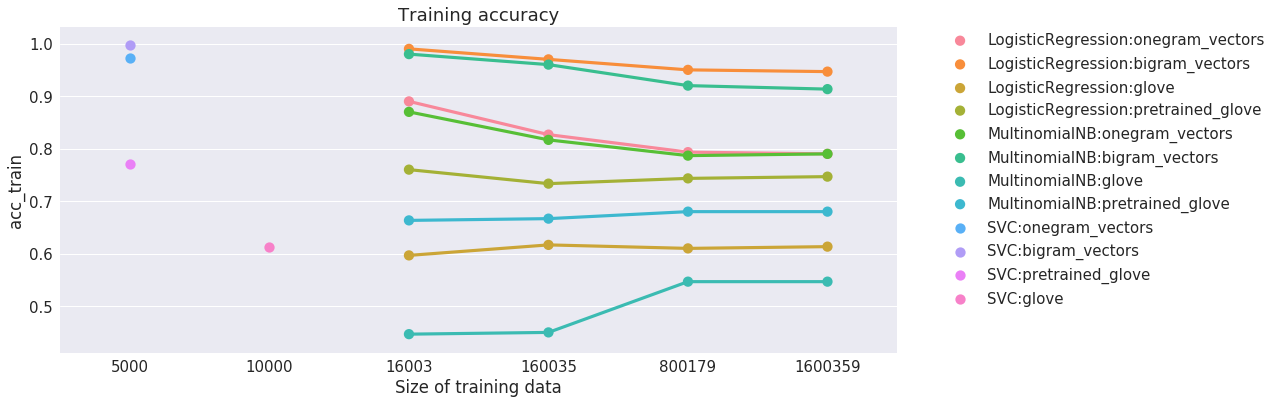

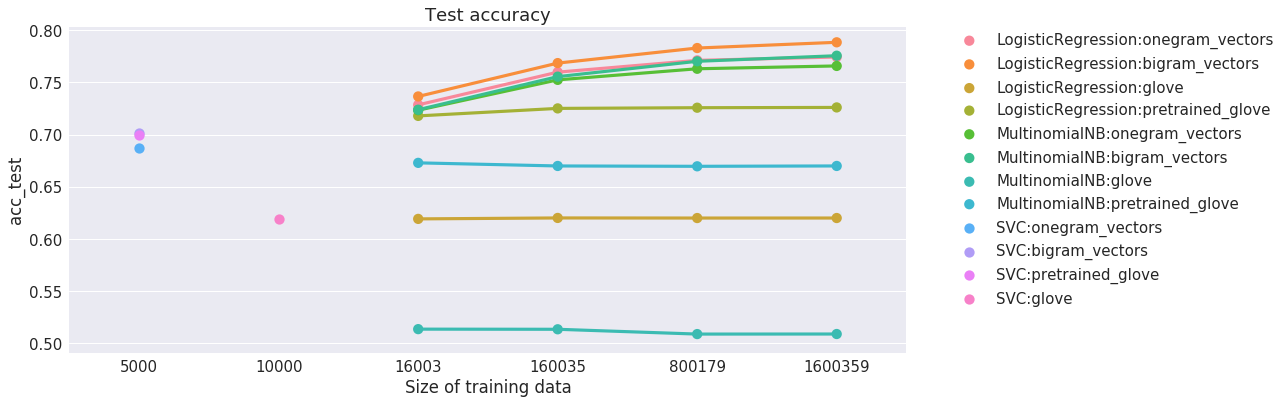

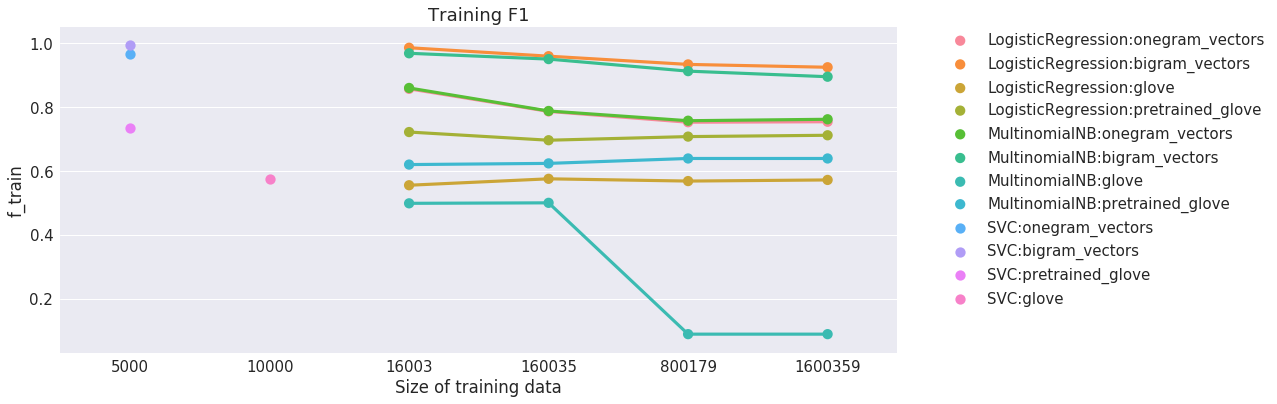

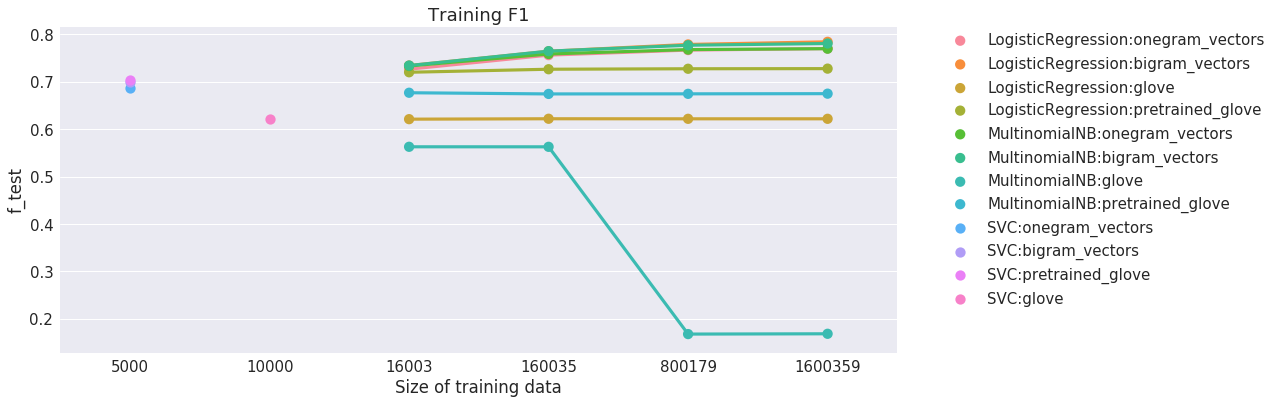

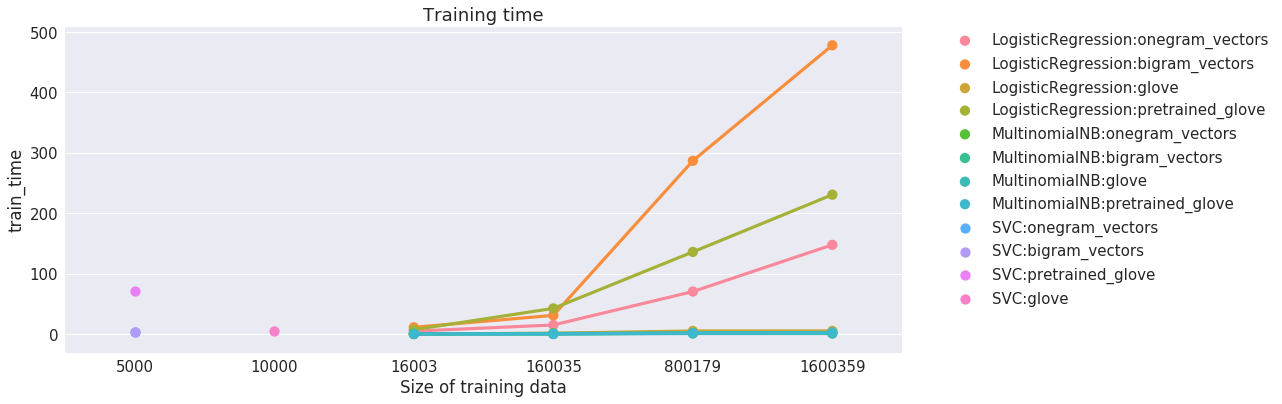

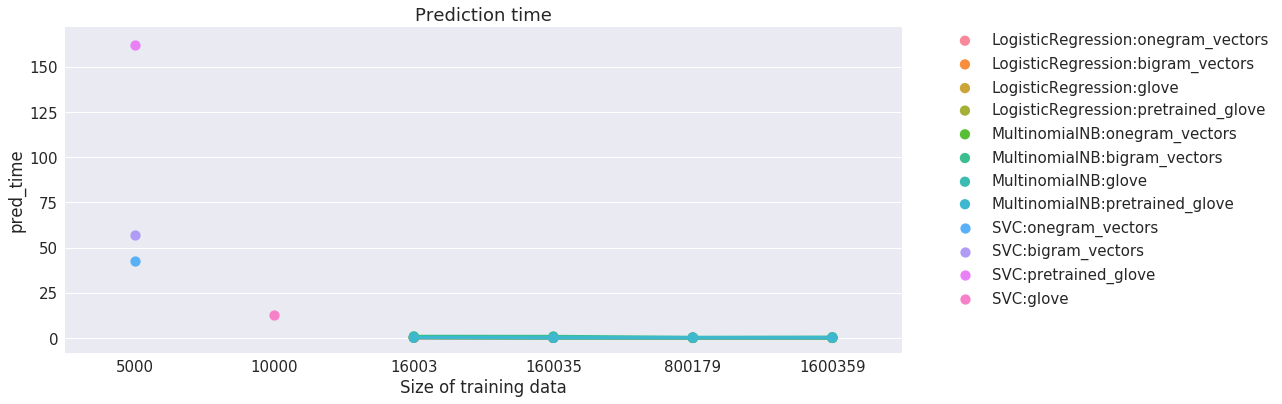

In [16]:
plots = [
    ["Training accuracy", "acc_train"],
    ["Test accuracy", "acc_test"],
    ["Training F1", "f_train"],
    ["Training F1", "f_test"],
    ["Training time", "train_time"],
    ["Prediction time", "pred_time"],
]

for plot in plots :
    plot_variable(plot[0], plot[1])

# Optimisation of best baseline model

In [ ]:
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
clf=LogisticRegression()
clf_cv=GridSearchCV(clf,grid,cv=10, n_jobs=-1)
best_clf = clf_cv.fit(X['bigram_vectors'][0],X['bigram_vectors'][2])

start = time() # Get start time
predictions_test = best_clf.predict(X['bigram_vectors'][1])
end = time() # Get end time
pred_time = end - start
acc_test = accuracy_score(X['bigram_vectors'][3], predictions_test)
f_test = fbeta_score(X['bigram_vectors'][3], predictions_test, average='binary', beta=0.5, pos_label=4)

print("tuned hpyerparameters :(best parameters) ",clf_cv.best_params_)
print("accuracy - validation set :",clf_cv.best_score_)
print('accuracy - test set :', acc_test)
print('f1 score - test set :', f_test)
print('prediction time - test set :', pred_time)